In [1]:
import networkx as nx
import random
import copy
from tqdm.notebook import tqdm

## Create

In [2]:
amazon_G = nx.read_graphml('./amazon_graph.graphml')

# Minimizar la distancia entre los nodos dentro de una comunidad
# Maximizar la distancia entre los nodos de disintas comunidades

In [3]:
def create_individuo(nodes_of_graph, adj_matrix, transformation):
    individuo =  [None] * len(nodes_of_graph)
    for i in range(len(nodes_of_graph)): #el individuo creado con el tipo locus tiene la longitud de los nodos

        
        nodo_vecino = random.choice(range(len(adj_matrix[i]))) #la matriz de adyacencia tiene los nodos vecinos, los nodos vecinos hay que convertirlos a numeros
        while adj_matrix[i][nodo_vecino] == 0 and nodo_vecino != i:
            nodo_vecino = random.choice(range(len(adj_matrix[nodo_vecino])))
        
        
        keys = list(transformation.keys())
        values = list(transformation.values())
        individuo[i] = keys[values.index(nodo_vecino)] # en el gen se pone el aleatorio de los vecinos pero transformado en el indice que le corresponde 
    return individuo

def create(nodes_of_graph, adj_matrix, transformation, N=100): # crea población, la transformacion debe de ser del tipo { numero_de_nodo_real : indice_del_array}, donde el indice del array va de 0 a len(nodos) - 1
    new_population = []
    for individuo in range(N):
        new_population.append(create_individuo(nodes_of_graph, adj_matrix, transformation))
    
    return new_population

In [4]:
conversiones = {}
for i, nodo in enumerate(amazon_G.nodes):
    conversiones[nodo] = i
print(conversiones)

{'75780': 0, '317458': 1, '186386': 2, '419862': 3, '176159': 4, '204831': 5, '104481': 6, '57383': 7, '401449': 8, '299055': 9, '176184': 10, '542780': 11, '366654': 12, '124992': 13, '16457': 14, '196682': 15, '546890': 16, '546891': 17, '34895': 18, '321619': 19, '112724': 20, '276567': 21, '55386': 22, '374874': 23, '55388': 24, '221281': 25, '432229': 26, '104553': 27, '383087': 28, '335987': 29, '448649': 30, '522378': 31, '59532': 32, '491667': 33, '518306': 34, '309411': 35, '182435': 36, '204966': 37, '532649': 38, '544939': 39, '542899': 40, '172218': 41, '270524': 42, '250046': 43, '204991': 44, '231620': 45, '497867': 46, '186575': 47, '346322': 48, '399572': 49, '276695': 50, '530647': 51, '18650': 52, '252125': 53, '59613': 54, '127199': 55, '379102': 56, '159972': 57, '366824': 58, '116969': 59, '202986': 60, '430314': 61, '350442': 62, '4328': 63, '458993': 64, '30962': 65, '35067': 66, '57600': 67, '217346': 68, '295177': 69, '49424': 70, '278': 71, '123159': 72, '3218

In [5]:
A = nx.to_numpy_array(amazon_G)

In [6]:
pop = create(amazon_G.nodes, A, conversiones)

## Fitness

In [7]:
def convert_individuo(individuo_raw, conversiones):
    new_individuo = [None] * len(individuo_raw)
    for i in range(len(individuo_raw)):
        new_individuo[i] = conversiones.get(str(individuo_raw[i]))
    
    return new_individuo
def unconvert_individuo(individuo, conversiones):
    individuo_raw =  [None] * len(individuo)
    keys = list(conversiones.keys())
    values = list(conversiones.values())
    for i in range(len(individuo)):
        individuo_raw[i] = keys[values.index(individuo[i])]
    return individuo_raw

def get_comunidades(individuo):

    G = nx.Graph()

    for i in range(len(individuo)):
        G.add_edge(i, individuo[i])

    comunidades = list(nx.connected_components(G))
    return comunidades

def get_cs(aristas_of_min_one_node_in_comunity, nodos_de_la_comunidad):
    cs = 0
    for aristas in aristas_of_min_one_node_in_comunity:
        if aristas[0] in nodos_de_la_comunidad and aristas[1] not in nodos_de_la_comunidad:
            cs += 1
            
        #elif aristas[1] in nodos_de_la_comunidad and aristas[0] not in nodos_de_la_comunidad:
        #    cs += 1
    return cs

def get_ms(aristas_of_min_one_node_in_comunity, nodos_de_la_comunidad):
    ms = 0
    for aristas in aristas_of_min_one_node_in_comunity:
        if aristas[0] in nodos_de_la_comunidad and aristas[1] in nodos_de_la_comunidad:
            ms += 1
            
        
    return ms

In [8]:
def fit_conductance(grafo,individuo,conversiones):
    conductance = 0
    individuo_converted = convert_individuo(individuo, conversiones)
    comunidades = get_comunidades(individuo_converted)
    for comunidad in comunidades:
        aristas_of_min_one_node_in_comunity = []
        comunidad_desconvertida = unconvert_individuo(list(comunidad), conversiones)
        for nodo_of_comunity in comunidad_desconvertida:

            aristas_of_min_one_node_in_comunity.append(list(grafo.edges(str(nodo_of_comunity)))[0])
        #aqui ya tenemos las aristas de los nodos para poder sacar el sm
        cs_community = get_cs(aristas_of_min_one_node_in_comunity, comunidad_desconvertida)
        ms_community = get_ms(aristas_of_min_one_node_in_comunity, comunidad_desconvertida)
        conductance += cs_community / (2*ms_community + cs_community)
        #
    
    return conductance
        
        
def fit_expansion(grafo,individuo,conversiones):
    expansion = 0
    individuo_converted = convert_individuo(individuo, conversiones)
    comunidades = get_comunidades(individuo_converted)
    for comunidad in comunidades:
        aristas_of_min_one_node_in_comunity = []
        comunidad_desconvertida = unconvert_individuo(list(comunidad), conversiones)
        for nodo_of_comunity in comunidad_desconvertida:

            aristas_of_min_one_node_in_comunity.append(list(grafo.edges(str(nodo_of_comunity)))[0])
        #aqui ya tenemos las aristas de los nodos para poder sacar el sm
        cs_community = get_cs(aristas_of_min_one_node_in_comunity, comunidad_desconvertida)
        ns_community = len(comunidad_desconvertida)
        expansion += cs_community / ns_community
        #
    
    return expansion


def fit_average_odf(grafo,individuo,conversiones):
    average_odf = 0
    individuo_converted = convert_individuo(individuo, conversiones)
    comunidades = get_comunidades(individuo_converted)
    for comunidad in comunidades:
        comunidad_desconvertida = unconvert_individuo(list(comunidad), conversiones)
        sum_nodos = 0
        for nodo_of_comunity in comunidad_desconvertida:
            aristas_del_nodo = list(grafo.edges(str(nodo_of_comunity)))[0]
            
            sum_nodos += get_cs(aristas_del_nodo,nodo_of_comunity) / len(aristas_del_nodo)
            #aristas_of_min_one_node_in_comunity.append(list(grafo.edges(str(nodo_of_comunity)))[0])
        average_odf += sum_nodos / len(comunidad)
        
        #aqui ya tenemos las aristas de los nodos para poder sacar el sm
        
        #
    
    return average_odf

def fit_Q(grafo,individuo,conversiones):
    Q = 0
    individuo_converted = convert_individuo(individuo, conversiones)
    comunidades = get_comunidades(individuo_converted)
    for comunidad in comunidades:
        aristas_of_min_one_node_in_comunity = []
        comunidad_desconvertida = unconvert_individuo(list(comunidad), conversiones)
        n_aristas = 0
        for nodo_of_comunity in comunidad_desconvertida:
            n_aristas += len(list(grafo.edges(str(nodo_of_comunity)))[0])
            aristas_of_min_one_node_in_comunity.append(list(grafo.edges(str(nodo_of_comunity)))[0])
        
        ms_community = get_ms(aristas_of_min_one_node_in_comunity, comunidad_desconvertida)
        cs_community = get_cs(aristas_of_min_one_node_in_comunity, comunidad_desconvertida)
        
        Q += ((ms_community/n_aristas) - (((ms_community + cs_community)/(2*n_aristas))**2))
    
    return Q

## Select, Mutate y Crossover

In [9]:
# def select (pop, fits, T): # devuelve un individuo seleccionado por torneo, devuelve una copia para evitar efectos laterales
#     seleccionados = random.sample(pop, T) #los 3 aleatorios
#     for i, indiv in enumerate(seleccionados):
#         es_dominante = True
#         for j, indiv2 in enumerate(seleccionados): 
#             if i == j:
#                 continue
            
#             if fits[i][0] > fits[j][0] and fits[i][1] > fits[j][1]:
#                 es_dominante = (True and es_dominante)
#             else:
#                 es_dominante = (False and es_dominante)
#         if es_dominante:
#             return indiv
#     return random.choice(seleccionados)

def select (pop, T): # devuelve un individuo seleccionado por torneo, devuelve una copia para evitar efectos laterales
    seleccionados = random.sample(pop, T) #los 3 aleatorios
    return copy.copy(pop[min([pop.index(x) for x in seleccionados])])


In [10]:
def mutate (grafo, ind, pmut, transformation): # la mutación consistirá en cambiar un elemento por otro posible nodo con el que este conectado
    probs = [random.random() for prob in range(len(ind))]
    nuevo_elem = copy.copy(ind)
    adj_matrix = nx.to_numpy_array(grafo)
    for i, probability in enumerate(probs):
      if probability < pmut:
            
        nodo_vecino = random.choice(range(len(adj_matrix[i]))) #la matriz de adyacencia tiene los nodos vecinos, los nodos vecinos hay que convertirlos a numeros
        
        while adj_matrix[i][nodo_vecino] == 0 and nodo_vecino != i:
            nodo_vecino = random.choice(range(len(adj_matrix[nodo_vecino])))
        
        keys = list(transformation.keys())
        values = list(transformation.values())
        nuevo_elem[i] = keys[values.index(nodo_vecino)] # en el gen se pone el aleatorio de los vecinos pero transformado en el indice que le corresponde 
    return nuevo_elem

In [11]:
def crossover (ind1, ind2, pcross, n_puntos = 1):
    copia_in1 = copy.copy(ind1)
    copia_in2 = copy.copy(ind2)
    if random.random() < pcross:
      punto = len(ind1) // (n_puntos+1)
      for i in range(n_puntos):
        index_fin = punto*(i+2)
        index_inicio = punto*(i+1)
        if index_fin < len(ind1):
          aux = copia_in1[index_inicio:index_fin]
          copia_in1[index_inicio:index_fin] = copia_in2[index_inicio:index_fin]
          copia_in2[index_inicio:index_fin] = aux
        else:
          aux = copia_in1[index_inicio:]
          copia_in1[index_inicio:] = copia_in2[index_inicio:]
          copia_in2[index_inicio:] = aux
    return copia_in1, copia_in2

# Evolve

In [12]:
def dominates(individual_A, individual_B, fit1_maximize, fit2_maximize):
    fit1_A, fit2_A = individual_A
    fit1_B, fit2_B = individual_B

    if fit1_maximize:
        dominates_fit1 = fit1_A > fit1_B
    else:
        dominates_fit1 = fit1_A < fit1_B

    if fit2_maximize:
        dominates_fit2 = fit2_A > fit2_B
    else:
        dominates_fit2 = fit2_A < fit2_B

    return dominates_fit1 and dominates_fit2

def get_pareto_front(pop, fits, fit1_maximize, fit2_maximize):
    pareto_front = []
    pareto_fits = []
    for i, fit in enumerate(fits):
        if not any(dominates(fit, fits[j], fit1_maximize, fit2_maximize) for j in range(len(pop)) if i != j):
            pareto_front.append(pop[i])
            pareto_fits.append(fits[i])
    return pareto_front, pareto_fits

Esta funcion añade a la poblacion de la siguiente generacion los individuos restantes para que de el tamaño de la poblacion total

In [13]:
# def get_pareto_fronts(pop, fits):
#     pareto_fronts = []
#     pareto_fits = []

#     remaining_pop = copy.copy(pop)
#     remaining_fits = copy.copy(fits)

#     while remaining_pop:
#         current_pareto, current_fits = get_pareto_front(remaining_pop, remaining_fits)
#         pareto_fronts.append(current_pareto)
#         pareto_fits.append(current_fits)

#         indices_to_remove = [remaining_pop.index(ind) for ind in current_pareto]
#         remaining_pop = [ind for i, ind in enumerate(remaining_pop) if i not in indices_to_remove]
#         remaining_fits = [fit for i, fit in enumerate(remaining_fits) if i not in indices_to_remove]

#     return pareto_fronts, pareto_fits

def sort_pop(pop, fits, fit1_maximize, fit2_maximize):
    pareto_fronts = []
    pareto_fits = []

    remaining_pop = copy.copy(pop)
    remaining_fits = copy.copy(fits)

    while remaining_pop:
        current_pareto, current_fits = get_pareto_front(remaining_pop, remaining_fits, fit1_maximize, fit2_maximize)
        pareto_fronts.extend(current_pareto)
        pareto_fits.extend(current_fits)

        indices_to_remove = [remaining_pop.index(ind) for ind in current_pareto]
        remaining_pop = [ind for i, ind in enumerate(remaining_pop) if i not in indices_to_remove]
        remaining_fits = [fit for i, fit in enumerate(remaining_fits) if i not in indices_to_remove]

    return pareto_fronts, pareto_fits

def select_resto_pop(len_pop, len_pareto_front, pop, fits, T=3):
    num_of_pop_to_fill = len_pop - len_pareto_front
    pop_fill = []
    for _ in range(num_of_pop_to_fill):
        ind = select(pop, fits, T)
        pop_fill.append(ind)
    return pop_fill

In [14]:
import matplotlib.pyplot as plt
def show_progress(pop, fit1, fit2):
    fitness1 = []
    fitness2 = []
    for ind in pop:
        fitness1.append(fit1(amazon_G, ind, conversiones))
        fitness2.append(fit2(amazon_G, ind, conversiones))

    print(f"fit1 : {fitness1}")
    print(f"fit2 : {fitness2}")

    plt.scatter(fitness1, fitness2)
    plt.xlabel('fit_average_odf')
    plt.ylabel('fit_Q')

    plt.show()


In [15]:
def evolve(pop, fit1, fit2, grafo, conversiones, T=3, pcross=0.8, pmut=0.2, n_puntos=1, n_gen=10, fit1_maximize=False, fit2_maximize=False, elitism=True):
    fitness1 = fit1 if fit1_maximize else lambda grafo, ind, conversione: 1 / (fit1(grafo, ind, conversione) + 1e-10)
    fitness2 = fit2 if fit2_maximize else lambda grafo, ind, conversione: 1 / (fit2(grafo, ind, conversione) + 1e-10)

    max_len = len(pop)
    new_pop = []


    for n in range(n_gen):
        print(f"N_GEN = {n}")

        pop = pop + new_pop
        unique_set = set(tuple(inner_list) for inner_list in pop)
        pop = [list(inner_tuple) for inner_tuple in unique_set]

        fits = [(fitness1(grafo, ind, conversiones), fitness2(grafo, ind, conversiones)) for ind in pop]

        pop, fitness = sort_pop(pop, fits, fit1_maximize, fit2_maximize)
        pop, fitness = pop[:max_len], fitness[:max_len]

        show_progress(pop, fitness1, fitness2)
        
        new_pop = []

        if elitism:
            new_pop.append(pop[0])

        for _ in range(int(len(pop)/2)):
            parent1 = select(pop, T)
            parent2 = select(pop, T)

            offspring1, offspring2 = crossover(parent1, parent2, pcross=pcross, n_puntos=n_puntos)

            offspring1 = mutate(amazon_G, offspring1, pmut=pmut, transformation=conversiones)
            offspring2 = mutate(amazon_G, offspring2, pmut=pmut, transformation=conversiones)

            new_pop.extend([offspring1, offspring2])

        

        

    fits = [(fitness1(grafo, ind, conversiones), fitness2(grafo, ind, conversiones)) for ind in pop]
    pop, fitness = sort_pop(pop, fits, fit1_maximize, fit2_maximize)
        
    return pop, fitness

    

N_GEN = 0
fit1 : [0.05410749269601779, 0.06747386687887622, 0.06565999307389363, 0.0739307147121462, 0.07120890901216141, 0.06495731610661667, 0.06676765030504837, 0.05008493979512747, 0.06564625899411113, 0.061326280368245306, 0.06556746130446955, 0.06278070928695133, 0.06347255128186352, 0.06991801015548527, 0.05978906165009591, 0.06399506033791033, 0.06304692697365706, 0.05258448029042223, 0.06327683256305838, 0.06287480489340766, 0.06254953464110571, 0.06965493721183887, 0.06605945350772097, 0.0648822560071067, 0.05815932420497017, 0.062493632519080286, 0.05801994149670538, 0.06777506112423504, 0.04822046531601758, 0.06303894429698574, 0.05655511179286243, 0.05793119047429514, 0.06681016730438681, 0.06187651800629922, 0.05190062068213062, 0.05430652291858871, 0.06214219250378872, 0.06718783098936071, 0.054896633697219886, 0.06459386759731983, 0.06146828927860538, 0.0550271203113814, 0.06515584486366398, 0.049520841844506454, 0.053363273996239836, 0.06319466166039232, 0.060330788184

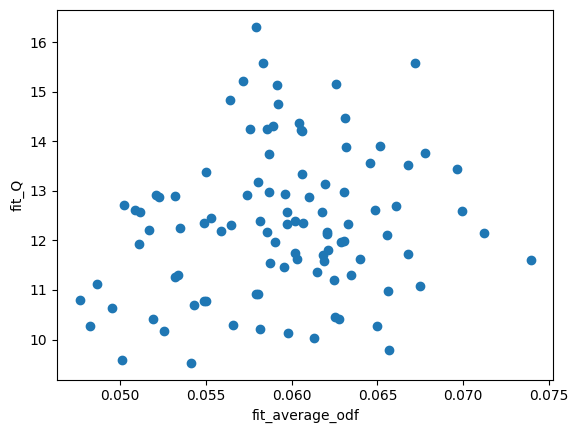

N_GEN = 1
fit1 : [0.06483914346165924, 0.06565999307389363, 0.07751151235217439, 0.05141511595964838, 0.06754007293785141, 0.05067930939803954, 0.06747386687887622, 0.07733033192775766, 0.06495731610661667, 0.06925843240461439, 0.055324505213486155, 0.06564625899411113, 0.0739307147121462, 0.06550071896975049, 0.05873271428548779, 0.06430870889975455, 0.07120890901216141, 0.07332073346196637, 0.05410749269601779, 0.06278070928695133, 0.05828732274654352, 0.05048398169194689, 0.07726153428119642, 0.06559260567877293, 0.07250203616002249, 0.06688317034775235, 0.061326280368245306, 0.07072477131913722, 0.06347255128186352, 0.06676765030504837, 0.05008493979512747, 0.05978906165009591, 0.06954196256551948, 0.06254953464110571, 0.075420566219875, 0.05386162083273198, 0.06399506033791033, 0.06556746130446955, 0.06568211786735846, 0.06994944359076126, 0.062493632519080286, 0.050046732651378475, 0.06991801015548527, 0.06196249873490723, 0.05258448029042223, 0.05964581679120526, 0.0701755033017

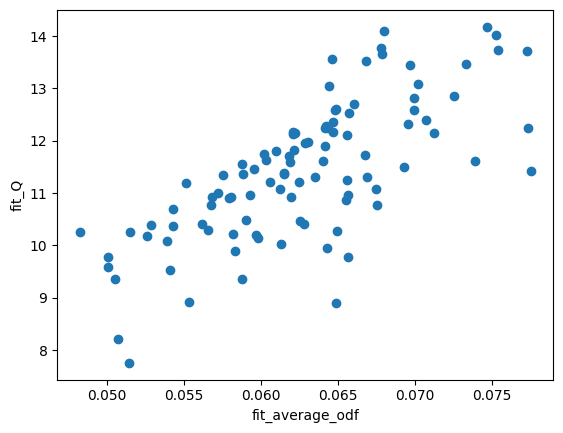

N_GEN = 2
fit1 : [0.05754396569654741, 0.06898002091730016, 0.06483914346165924, 0.07442565937937477, 0.0780837786544995, 0.07751151235217439, 0.05141511595964838, 0.06629212387333087, 0.07733033192775766, 0.0720450699761182, 0.055324505213486155, 0.0739307147121462, 0.06297455348845181, 0.0687935406304492, 0.06619747701524523, 0.05873271428548779, 0.05099362282523046, 0.057675161009830035, 0.07197564197370976, 0.07120890901216141, 0.05067930939803954, 0.07332073346196637, 0.05410749269601779, 0.07000145496370601, 0.06925843240461439, 0.06565999307389363, 0.07726153428119642, 0.06392716077826023, 0.07250203616002249, 0.06754007293785141, 0.07153891248192987, 0.05560721517319561, 0.06919373771280127, 0.07072477131913722, 0.06747386687887622, 0.06574031795283689, 0.05521703293848689, 0.06992607269994368, 0.06564625899411113, 0.058828656641468545, 0.05048398169194689, 0.06498350797293297, 0.06550071896975049, 0.059489359313031474, 0.075420566219875, 0.06955900644500664, 0.0723474992767243

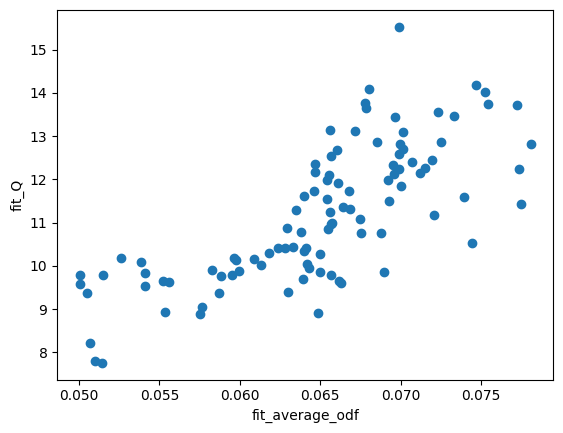

N_GEN = 3
fit1 : [0.06898002091730016, 0.06623609018496264, 0.06483914346165924, 0.07442565937937477, 0.0780837786544995, 0.05942479352545117, 0.055908211921691625, 0.07751151235217439, 0.06760325867081596, 0.05141511595964838, 0.06987991465671589, 0.06876614768153633, 0.05754396569654741, 0.07733033192775766, 0.0720450699761182, 0.0739307147121462, 0.0687935406304492, 0.0697948571621052, 0.06294292221332366, 0.06751099561345986, 0.05099362282523046, 0.07197564197370976, 0.07120890901216141, 0.05067930939803954, 0.07000145496370601, 0.06925843240461439, 0.055324505213486155, 0.06156109719314042, 0.06940261489156371, 0.06297455348845181, 0.07503504659576588, 0.07726153428119642, 0.06659678590539807, 0.06754007293785141, 0.06728628163352357, 0.06629212387333087, 0.07153891248192987, 0.06833081283300632, 0.057675161009830035, 0.07332073346196637, 0.06919373771280127, 0.07072477131913722, 0.06747386687887622, 0.06992607269994368, 0.06484278816156754, 0.06619747701524523, 0.0587327142854877

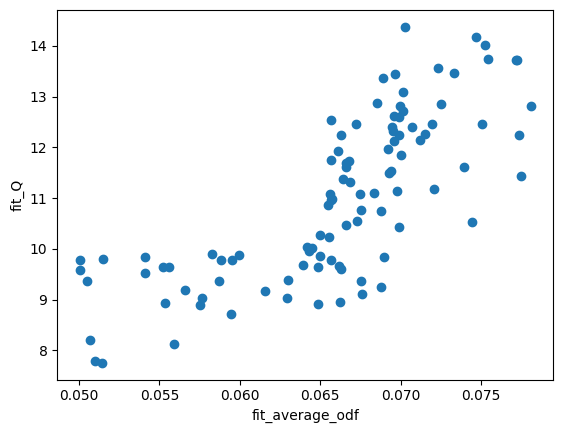

N_GEN = 4
fit1 : [0.06898002091730016, 0.07442565937937477, 0.0780837786544995, 0.07751151235217439, 0.06760325867081596, 0.06987991465671589, 0.06635513957657038, 0.06876614768153633, 0.07733033192775766, 0.0720450699761182, 0.06623609018496264, 0.06483914346165924, 0.0739307147121462, 0.0687935406304492, 0.05942479352545117, 0.055908211921691625, 0.07321356550827281, 0.05141511595964838, 0.0697948571621052, 0.0778857962566588, 0.06751099561345986, 0.05754396569654741, 0.07325933456999448, 0.06326474999203441, 0.06925843240461439, 0.06940261489156371, 0.07503504659576588, 0.07726153428119642, 0.06659678590539807, 0.06754007293785141, 0.06728628163352357, 0.06629212387333087, 0.06833081283300632, 0.06294292221332366, 0.05099362282523046, 0.07207382982683075, 0.07197564197370976, 0.07120890901216141, 0.05067930939803954, 0.07332073346196637, 0.06747386687887622, 0.07000145496370601, 0.055324505213486155, 0.06156109719314042, 0.06297455348845181, 0.06484278816156754, 0.06619747701524523,

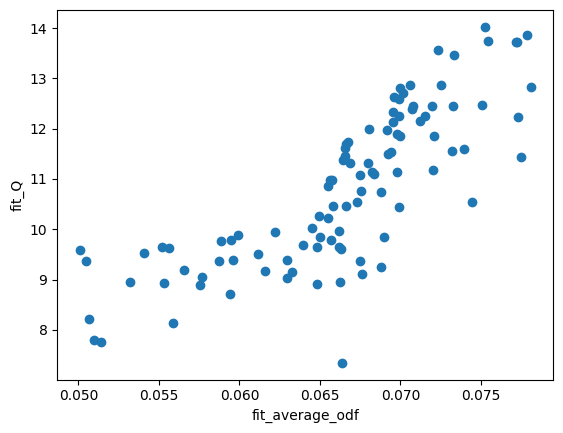

N_GEN = 5
fit1 : [0.07442565937937477, 0.0780837786544995, 0.07751151235217439, 0.06760325867081596, 0.06635513957657038, 0.07423895968356936, 0.06898002091730016, 0.07778422503396816, 0.0722773350189187, 0.07046777010992394, 0.07733033192775766, 0.06623609018496264, 0.06483914346165924, 0.0739307147121462, 0.06175305117287672, 0.055908211921691625, 0.05141511595964838, 0.0778857962566588, 0.0736503242826606, 0.06876614768153633, 0.07602948043256973, 0.0720450699761182, 0.07325933456999448, 0.06326474999203441, 0.07188785547411362, 0.07503504659576588, 0.05942479352545117, 0.06831003848078147, 0.07321356550827281, 0.07726153428119642, 0.07037182033870082, 0.06987991465671589, 0.06294292221332366, 0.06751099561345986, 0.05099362282523046, 0.05067930939803954, 0.05754396569654741, 0.06156109719314042, 0.06297455348845181, 0.0687935406304492, 0.07456804927993696, 0.07400924510254273, 0.06659678590539807, 0.07717663943103104, 0.0697948571621052, 0.06728628163352357, 0.06629212387333087, 0.

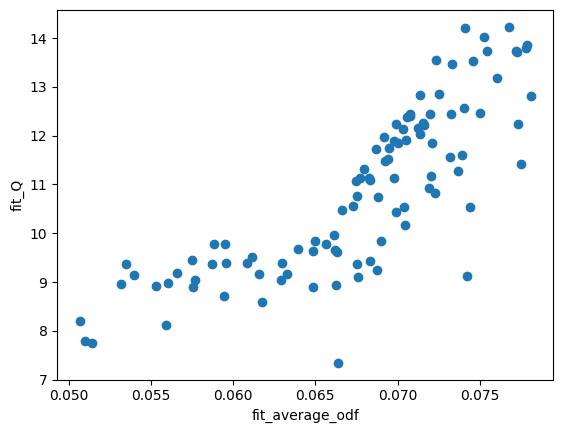

N_GEN = 6
fit1 : [0.07442565937937477, 0.0780837786544995, 0.07751151235217439, 0.06760325867081596, 0.06635513957657038, 0.07423895968356936, 0.06898002091730016, 0.07778422503396816, 0.0722773350189187, 0.07046777010992394, 0.07733033192775766, 0.06623609018496264, 0.0739307147121462, 0.055908211921691625, 0.06561289637072576, 0.07615882335447546, 0.07126089190033535, 0.05141511595964838, 0.0778857962566588, 0.0736503242826606, 0.060044692398472405, 0.06876614768153633, 0.07602948043256973, 0.0720450699761182, 0.07325933456999448, 0.0673249885878621, 0.07188785547411362, 0.06483914346165924, 0.06175305117287672, 0.06938472210253163, 0.07503504659576588, 0.06831003848078147, 0.07321356550827281, 0.07726153428119642, 0.07037182033870082, 0.06987991465671589, 0.06751099561345986, 0.05099362282523046, 0.05067930939803954, 0.06326474999203441, 0.0692221454453488, 0.06825816493184629, 0.0687935406304492, 0.05942479352545117, 0.07456804927993696, 0.07400924510254273, 0.06659678590539807, 0.

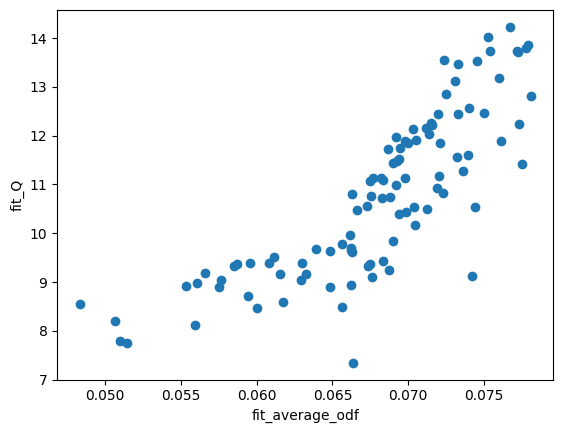

N_GEN = 7
fit1 : [0.07442565937937477, 0.07751151235217439, 0.06760325867081596, 0.06635513957657038, 0.07423895968356936, 0.07967052819678543, 0.06486662809894275, 0.06898002091730016, 0.0722773350189187, 0.07046777010992394, 0.07733033192775766, 0.06886213855813345, 0.06623609018496264, 0.07254171261119682, 0.0780837786544995, 0.06561289637072576, 0.07483599423749783, 0.07615882335447546, 0.07126089190033535, 0.0736503242826606, 0.059986113945466345, 0.07778422503396816, 0.07602948043256973, 0.06283059961492102, 0.0720450699761182, 0.07188785547411362, 0.06483914346165924, 0.0739307147121462, 0.06528341923043153, 0.06938472210253163, 0.055908211921691625, 0.07321356550827281, 0.07726153428119642, 0.07570085327616623, 0.05141511595964838, 0.0778857962566588, 0.07037182033870082, 0.06987991465671589, 0.06881537483123788, 0.06876614768153633, 0.0631202705991233, 0.06326474999203441, 0.0673249885878621, 0.0692221454453488, 0.06175305117287672, 0.07503504659576588, 0.0687935406304492, 0.0

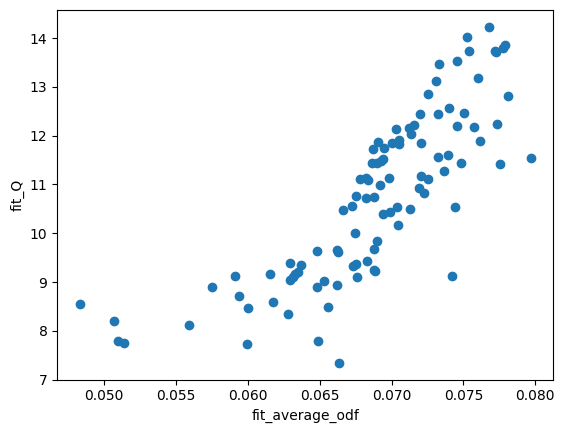

N_GEN = 8
fit1 : [0.07442565937937477, 0.0669068212589103, 0.06760325867081596, 0.07801714901841986, 0.08055028687798597, 0.06635513957657038, 0.07423895968356936, 0.07967052819678543, 0.06486662809894275, 0.06898002091730016, 0.07046777010992394, 0.06886213855813345, 0.06623609018496264, 0.0780837786544995, 0.07751151235217439, 0.07260989635747023, 0.06561289637072576, 0.06591659709347054, 0.0736503242826606, 0.059986113945466345, 0.07778422503396816, 0.06283059961492102, 0.0722773350189187, 0.0774212547549192, 0.07733033192775766, 0.06483914346165924, 0.07254171261119682, 0.06528341923043153, 0.06938472210253163, 0.055908211921691625, 0.07483599423749783, 0.07615882335447546, 0.07126089190033535, 0.05141511595964838, 0.0778857962566588, 0.05540539164256607, 0.06987991465671589, 0.06881537483123788, 0.06876614768153633, 0.0631202705991233, 0.07602948043256973, 0.0720450699761182, 0.06326474999203441, 0.052225461408309706, 0.0673249885878621, 0.07188785547411362, 0.0739307147121462, 0.

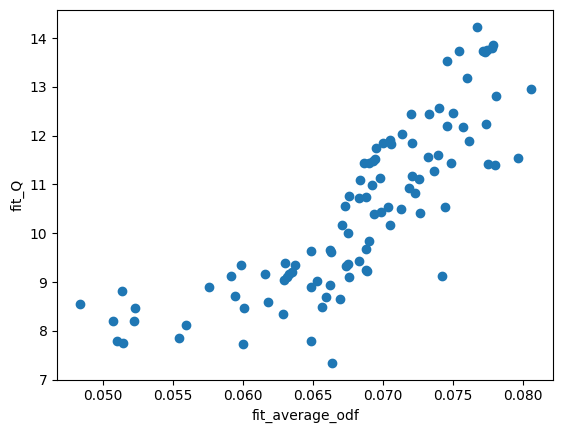

N_GEN = 9
fit1 : [0.061820527559318286, 0.06644183797213865, 0.0669068212589103, 0.08190748215445914, 0.07801714901841986, 0.08055028687798597, 0.06635513957657038, 0.07967052819678543, 0.07685978503765414, 0.06486662809894275, 0.0663705418293819, 0.07442565937937477, 0.0780837786544995, 0.07751151235217439, 0.06760325867081596, 0.07423895968356936, 0.059986113945466345, 0.06898002091730016, 0.07778422503396816, 0.06283059961492102, 0.0774212547549192, 0.07046777010992394, 0.07733033192775766, 0.06886213855813345, 0.06623609018496264, 0.055908211921691625, 0.07260989635747023, 0.06561289637072576, 0.07483599423749783, 0.07615882335447546, 0.05141511595964838, 0.07738746394788136, 0.0778857962566588, 0.05540539164256607, 0.06591659709347054, 0.0736503242826606, 0.07602948043256973, 0.052225461408309706, 0.07315539481904541, 0.06529746919263046, 0.07243721394474455, 0.07254171261119682, 0.0739307147121462, 0.05223881755163282, 0.06175305117287672, 0.06938472210253163, 0.07321356550827281

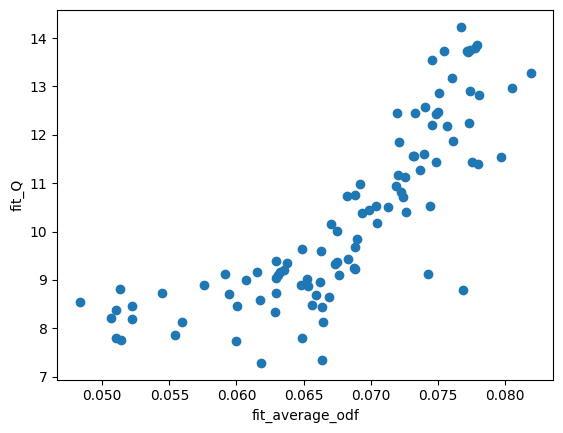

[['182923',
  '317458',
  '521655',
  '419862',
  '30962',
  '159972',
  '104481',
  '389895',
  '198973',
  '299055',
  '176184',
  '16457',
  '123953',
  '49424',
  '216152',
  '16457',
  '546890',
  '109595',
  '67572',
  '321619',
  '114378',
  '80756',
  '99182',
  '374874',
  '41336',
  '353264',
  '279830',
  '418177',
  '313307',
  '57383',
  '361524',
  '64879',
  '521655',
  '394886',
  '518306',
  '252719',
  '521655',
  '225233',
  '85382',
  '221801',
  '9762',
  '172218',
  '114379',
  '204126',
  '204991',
  '277713',
  '497867',
  '423306',
  '346322',
  '399572',
  '511063',
  '521655',
  '401170',
  '401798',
  '59613',
  '208714',
  '49424',
  '28513',
  '366824',
  '141618',
  '345901',
  '430314',
  '476448',
  '4328',
  '229209',
  '475666',
  '35067',
  '14076',
  '504412',
  '150207',
  '325052',
  '278',
  '193240',
  '480479',
  '480479',
  '202986',
  '500861',
  '373799',
  '352552',
  '14073',
  '330328',
  '330328',
  '132756',
  '546891',
  '230788',
  '4

In [19]:
evolved_pop, fitness = evolve(pop, fit_average_odf, fit_Q, amazon_G, conversiones, T=10, n_gen=10, fit1_maximize=False, fit2_maximize=True, pcross=0.8, pmut=0.7)
evolved_pop

long 100
fit1 : [18.481728687978688, 14.820552700623695, 15.22997419247419, 13.52617790706026, 14.0431866442736, 15.394724719724717, 14.977313046430693, 19.966081702114312, 15.233160507792858, 16.306222943722943, 15.25146742146742, 15.928459734709737, 15.75484173549189, 14.30246652856947, 16.725467374723667, 15.626206065176655, 15.8612012987013, 19.017017843891903, 15.803572326366442, 15.904621917937137, 15.98732917409388, 14.35648412045471, 15.137878787878787, 15.412534358915934, 17.19414751914752, 16.001630241103925, 17.235453435453437, 14.754689754689753, 20.738082750582752, 15.863209816499289, 17.68186762068341, 17.26185828060828, 14.967781706597496, 16.16121967128159, 19.26759231107057, 18.413994235898265, 16.09212613367025, 14.883647608026411, 18.216053201184778, 15.481345786995936, 16.268551015977483, 18.17285720815132, 15.347817253938533, 20.193517774496033, 18.739479891453573, 15.824121432403162, 16.57528486006747, 16.10583940053754, 16.180520150643993, 18.79023331740723, 16.7

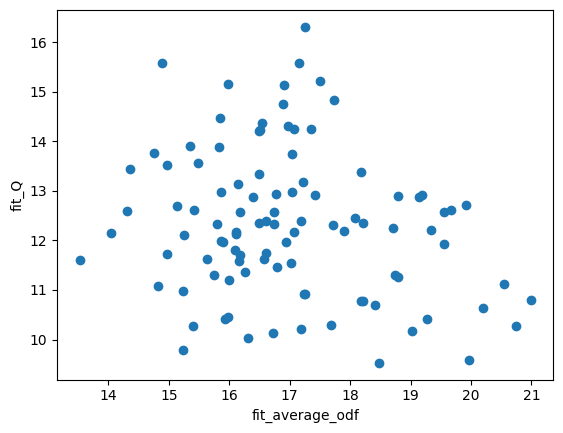

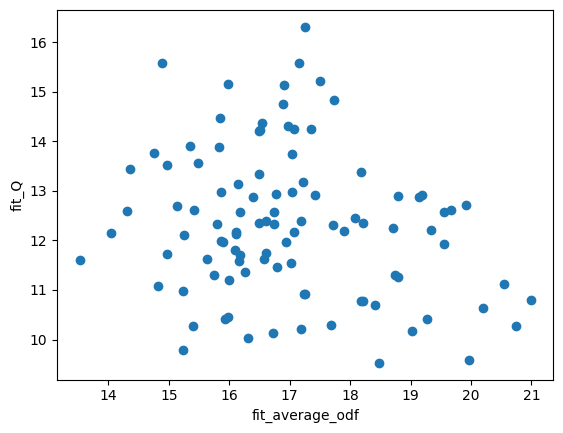

In [17]:
import matplotlib.pyplot as plt

# pop = create(amazon_G.nodes, A, conversiones)

print(f"long {len(evolved_pop)}")
fits1 = []
fits2 = []

for ind in evolved_pop:
    fits1.append(fit_average_odf(amazon_G, ind, conversiones))
    fits2.append(fit_Q(amazon_G, ind, conversiones))

print(f"fit1 : {fits1}")
print(f"fit2 : {fits2}")

plt.scatter(fits1, fits2)
plt.xlabel('fit_average_odf')
plt.ylabel('fit_Q')

plt.show()

fits1 = []
fits2 = []

for ind in pop:
    fits1.append(fit_average_odf(amazon_G, ind, conversiones))
    fits2.append(fit_Q(amazon_G, ind, conversiones))

plt.scatter(fits1, fits2)
plt.xlabel('fit_average_odf')
plt.ylabel('fit_Q')

plt.show()


In [18]:
get_comunidades(evolved_pop[0])

[{0, 338, '423864'},
 {1, 256, 294, 339, '500865'},
 {2, 345, 357, 439, 447, 468, '521655', 99},
 {3, '98081'},
 {'190765', 246, 4, 95},
 {'379184', 5, 86},
 {'104481', 6},
 {29, '335987', 39, 7},
 {395, '470620', 8},
 {'186386', 9},
 {10, '256445'},
 {11, 384, '9762'},
 {12, '366654'},
 {13, 346, 352, '49424'},
 {14, 386, '542780'},
 {15, 268, '542899'},
 {16, '270524', 42},
 {'126433', 17, 82},
 {18, 59, '67572'},
 {19, '475666', 84},
 {'112724', 20},
 {21, '276567', 430},
 {215, 22, '55386'},
 {226, 23, '33710'},
 {207, 24, '55388'},
 {'202986', 25},
 {250, 26, '392463'},
 {27, '287524'},
 {120, 28, '289953'},
 {30, '448649'},
 {31, '329078', 337},
 {32, '59532'},
 {33, '491667'},
 {34, '60211'},
 {138, '252719', 35},
 {'182435', 36},
 {119, 37, '77701'},
 {271, 38, '532649'},
 {'196682', 40},
 {'203272', 281, 41},
 {'204126', 332, 43},
 {136, 217, 44, '498193'},
 {'277713', 45},
 {285, '326849', 46, 98},
 {'186575', 190, 47},
 {287, '435398', 48},
 {'123953', 49},
 {'276695', 50},
